In [1]:
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak
from coffea import hist, processor
import coffea
import uproot
import sys
sys.path.insert(0,"../")
# from corrections import add_pileup_weight

import pickle
import glob

import mplhep as hep
plt.style.use(hep.style.CMS) 
import pandas as pd

In [2]:
def relabel(h):
    a = h.axis('dataset')
    for s in a.identifiers():
        if "testpoint" in s.name or "=" in s.name or len(s.name.split("_"))==0: continue
        if "HNL" in s.name:
            if "electron" in s.name: flavour = "e"
            elif "muon" in s.name: flavour ="\mu"
            if "rwctau" in s.name:
                m = float(s.name.split("_")[-3].replace("mHNL","").replace("p","."))
                ct = int(s.name.split("_")[-1].replace("rwctau",""))
#                 print("m=%s,ct=%s"%(m,ct)    )                
            else:
                m = float(s.name.split("_")[-2].replace("mHNL","").replace("p","."))
                ct = int(s.name.split("_")[-1].replace("pl",""))
#                 print("m=%s,ct=%s"%(m,ct)    )
            a.index(s).label = r"$m_{HNL}^{%s}=%s GeV,c\tau$=%s m"%(flavour,m,ct/1000)
        elif "WJets" in s.name:
            a.index(s).label = "Wjets"
    return 

def rename(name):
    if "HNL" in name:
        m = name.split("_")[2].replace("mHNL","").replace("p0","GeV")
        if "rwctau" in name:
            ct = (name.split("_")[-1].replace("rwctau",""))
        else:
            ct = (name.split("_")[-1].replace("pl",""))
        label = "_".join([m,ct+"mm"])
    elif "WJet" in name:
        label= "WJetsToLNu"
    elif "EGamma" in name:
        label = "EGamma"
    return label
    

In [3]:
import HNLprocessor.corrections as corrections

xsections = corrections.load_xsection()

# with open('../HNL_histograms_Mar15_muons_signal_Wpt.pickle','rb') as f:                
with open('../HNL_histograms_Mar15_muons_signal.pickle','rb') as f:                
# with open('../HNL_histograms_Mar15_ele_signal.pickle','rb') as f:                
# with open('../test.pickle','rb') as f:                    
    out = pickle.load(f)
    
lumi = 137 ## fb
    
for k,h in out.items():
#     print(k,)
    if (type(h)!=hist.Hist): continue
    h.scale({ d: lumi for d in h.identifiers("dataset") if not "2018" in d.name}, axis="dataset")
#     relabel(h)

In [9]:
out['metXYCorr'].identifiers("region")

[<StringBin (ABCD) instance at 0x7f0c930da5d0>,
 <StringBin (ABCD_OOT) instance at 0x7f0c92ebc890>,
 <StringBin (PreSel) instance at 0x7f0c930dab10>,
 <StringBin (gLLP_csc) instance at 0x7f0c930da8d0>,
 <StringBin (gLLP_dt) instance at 0x7f0c930daa90>,
 <StringBin (noselection) instance at 0x7f0c930da910>]

## Cutflow tables

In [10]:
out['sumw']

defaultdict_accumulator(float,
                        {'HNL_electronType_mHNL1p0_pl10000': 497066.0,
                         'WJetsToLNu_TuneCP5_13TeV-madgraphMLM-pythia8': 1297009.0,
                         'HNL_electronType_mHNL4p0_pl1000': 660231.0,
                         'HNL_electronType_mHNL4p0_pl100_rwctau80': 661978.0,
                         'HNL_electronType_mHNL2p0_pl10000_rwctau5000': 444875.0})

In [11]:
[ d.name for d in out['cutflow'].identifiers("dataset")]

['HNL_electronType_mHNL1p0_pl10000',
 'HNL_electronType_mHNL2p0_pl10000_rwctau5000',
 'HNL_electronType_mHNL4p0_pl1000',
 'HNL_electronType_mHNL4p0_pl100_rwctau80',
 'WJetsToLNu_TuneCP5_13TeV-madgraphMLM-pythia8']

In [173]:
np.concatenate((np.array([2.90253250e+04]),np.array([ 2.38646033e-03])))

array([2.90253250e+04, 2.38646033e-03])

In [208]:
np.arange(10)[2:]

array([2, 3, 4, 5, 6, 7, 8, 9])

In [234]:
data[1]

0.0014764176458396958

In [4]:
h = out['cutflow'].integrate("region",'csc_cutflow')

datasets = [
#  'HNL_muonType_mHNL1p0_pl10000',
 'HNL_muonType_mHNL1p0_pl10000_rwctau20000',
 'HNL_muonType_mHNL2p0_pl10000_rwctau5000',
 'HNL_muonType_mHNL4p0_pl1000',
 'HNL_muonType_mHNL4p0_pl100_rwctau80',
#  'WJetsToLNu_TuneCP5_13TeV-madgraphMLM-pythia8'
]

table = {}
table_rel = {}
for d in datasets: 
    h_vals = h.integrate("dataset",d).values()
    cutnames = [cut[0] for cut,vals in h_vals.items()]
    data = [vals for cut,vals in h_vals.items()]
    label= rename(d)    
    acc = data[1]
    data[1] = data[1]/data[0]
    table[label] = np.round(np.insert(data[2:]/acc, 0,data[1]),5)*100
#     table[label]= np.round(data)
#     table_rel[label] = np.round(data[1]+data[1:]/data[2:,5)*100    
# print(table)
import pandas as pd
df = pd.DataFrame.from_dict(table,orient="index",columns=cutnames[1:]).transpose()

In [34]:
df

,1GeV_20000mm,2GeV_5000mm,4GeV_1000mm,4GeV_80mm
Acceptance_csc,0.147,1.104,5.878,1.868
trigger_mu,42.331,42.567,47.923,48.603
MET,27.832,29.076,33.595,37.670
METfilters,27.706,28.979,33.551,37.613
good_lepton,25.284,26.903,30.689,33.683
n_cls,10.758,11.761,15.636,19.643
jetVeto_mask,8.991,9.847,13.327,16.912
muonVeto_mask,8.206,9.239,12.658,16.072
ME11_12_veto,5.563,6.900,8.988,9.968
MB1seg_veto,5.563,6.815,8.878,9.935


In [5]:
h = out['cutflow'].integrate("region",'csc_cutflow')

table = {}
for d in datasets: 
    h_vals = h.integrate("dataset",d).values()
    cutnames = [cut[0] for cut,vals in h_vals.items()]
    data = np.array([vals for cut,vals in h_vals.items()])    
    label= rename(d)    
    
#     table[label] = np.round(data,2)
    table[label] = data

import pandas as pd
df = pd.DataFrame.from_dict(table,orient="index",columns=cutnames).transpose()

In [6]:
df

,1GeV_20000mm,2GeV_5000mm,4GeV_1000mm,4GeV_80mm
NoSelection,52.411955,6.598947,0.999872,12.498714
Acceptance_csc,0.076845,0.072844,0.058768,0.233520
trigger_mu,0.032529,0.031007,0.028163,0.113498
MET,0.021387,0.021180,0.019743,0.087966
METfilters,0.021290,0.021110,0.019717,0.087834
good_lepton,0.019429,0.019597,0.018035,0.078658
n_cls,0.008267,0.008567,0.009189,0.045870
jetVeto_mask,0.006909,0.007173,0.007832,0.039492
muonVeto_mask,0.006305,0.006730,0.007439,0.037531
ME11_12_veto,0.004275,0.005026,0.005282,0.023277


In [31]:
np.array([vals for cut,vals in cut_vals.items()])

array([16.96370344,  7.07961879,  4.61153056,  4.59165674,  4.16606733,
        0.26785224,  0.2552646 ,  0.10853817,  0.10534298,  0.10327405,
        0.09058495,  0.17733407,  0.05047898])

In [30]:
cut_vals = out['cutflow'].integrate("region","csc_cutflow").integrate("dataset","HNL_muonType_mHNL4p0_pl1000").values()

In [55]:

[s.name for s in out['metXYCorr'].axis('dataset').identifiers()]

['HNL_muonType_mHNL1p0_pl10000_rwctau20000',
 'HNL_muonType_mHNL2p0_pl10000_rwctau5000',
 'HNL_muonType_mHNL4p0_pl1000',
 'HNL_muonType_mHNL4p0_pl100_rwctau80',
 'HNL_tauType_mHNL2p0_pl1000',
 'WJetsToLNu_TuneCP5_13TeV-madgraphMLM-pythia8']

In [6]:
h=out['ClusterSize']
h.sum("dataset","region","ClusterSize").values()

{(): 10923.0}

In [9]:
out['dphi_cluster_csc'].identifiers("region")

[<StringBin (ABCD) instance at 0x7f0d2bccff10>,
 <StringBin (ABCD_OOT) instance at 0x7f0d2bccff50>]

In [70]:
out['dphi_cluster_dt'].identifiers("region")

[<StringBin (ABCD_dt) instance at 0x7f5df28e3610>,
 <StringBin (ABCD_dt_OOT) instance at 0x7f5df28e3350>]

# Signal gen

In [5]:
signals = [
'HNL_muonType_mHNL1p0_pl10000_rwctau20000',
 'HNL_muonType_mHNL2p0_pl10000_rwctau5000',
 'HNL_muonType_mHNL4p0_pl1000',
 'HNL_muonType_mHNL4p0_pl100_rwctau80',
]
signals_bkg=signals+[     'WJetsToLNu_TuneCP5_13TeV-madgraphMLM-pythia8']
bkg = [     'WJetsToLNu_TuneCP5_13TeV-madgraphMLM-pythia8']

In [22]:
channel = "muon"
region = "gLLP_dt"
region_ext = "dt"
# region = "gLLP_csc"
# region_ext = "csc"

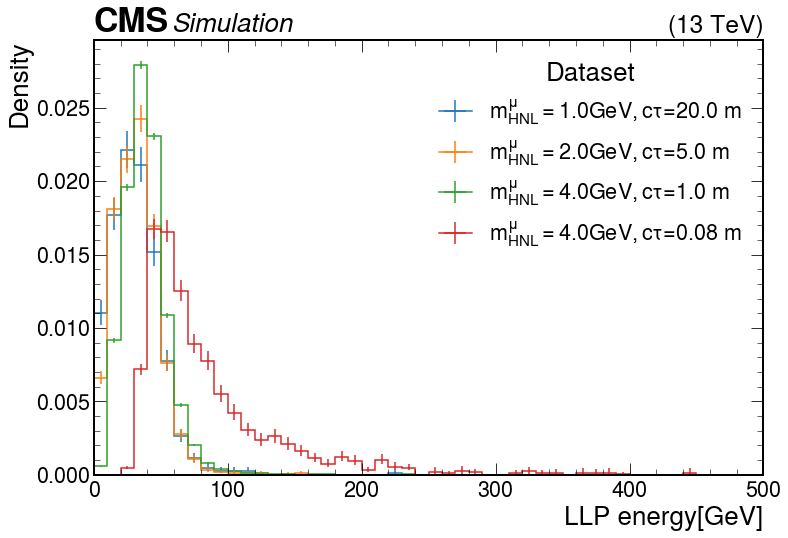

In [16]:
plt.style.use(hep.style.CMS) 

h = out['gLLP_e'].integrate("region",region)
h.label="Density"

fig, axs = plt.subplots(1,1, figsize=(12,8))
relabel(h)

hist.plot1d(h[signals],density=True)

hep.cms.label(ax=axs)
fig.savefig("figures/gLLP_e_%s.pdf"%region_ext)

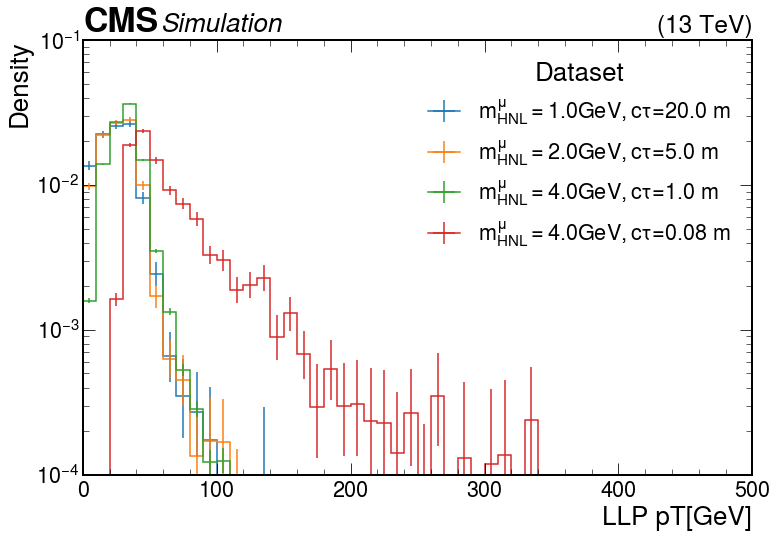

In [18]:
plt.style.use(hep.style.CMS) 
h = out['gLLP_pt'].integrate("region",region)
h.label="Density"

fig, axs = plt.subplots(1,1, figsize=(12,8))
relabel(h)

hist.plot1d(h[signals],density=True)
axs.set_yscale("log")
axs.set_ylim(1e-4,1e-1)
hep.cms.label(ax=axs)
fig.savefig("figures/gLLP_pt_%s.pdf"%region_ext)

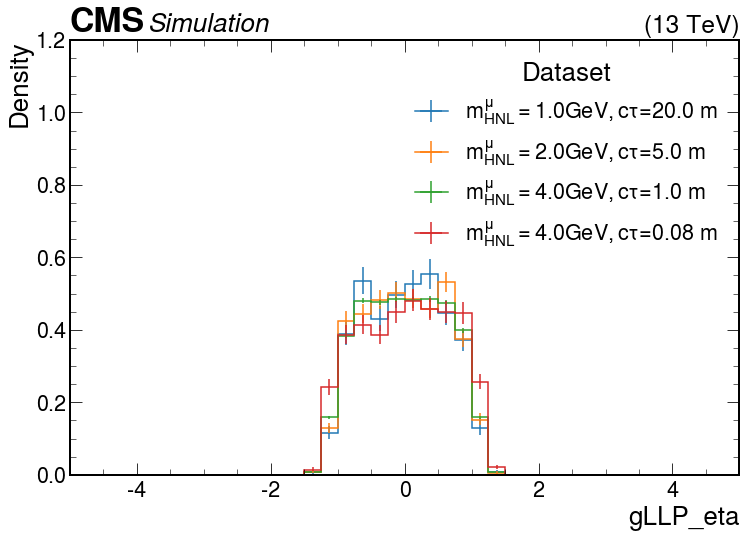

In [19]:
plt.style.use(hep.style.CMS) 
h = out['gLLP_eta'].integrate("region",region)
h.label="Density"

fig, axs = plt.subplots(1,1, figsize=(12,8))
relabel(h)

hist.plot1d(h[signals],density=True)
# axs.set_yscale("log")
axs.set_ylim(None,1.2)
hep.cms.label(ax=axs)
fig.savefig("figures/gLLP_eta_%s.pdf"%region_ext)

NameError: name 'channel' is not defined

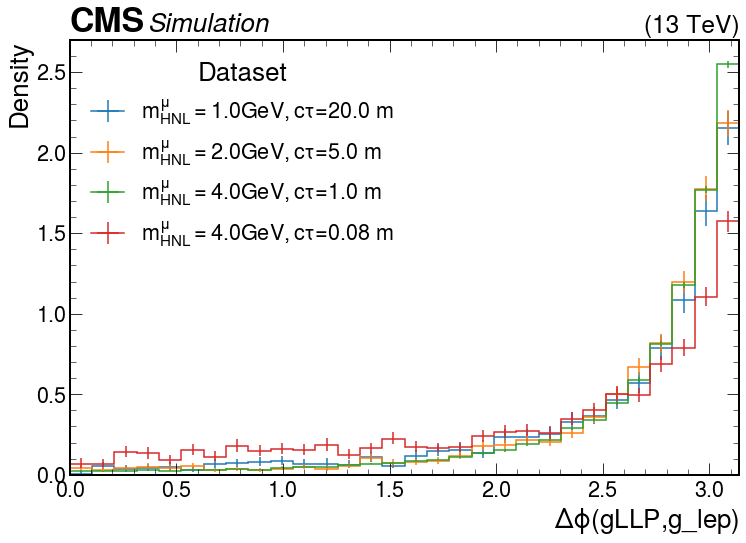

In [21]:
plt.style.use(hep.style.CMS) 
h = out['glepdPhi'].integrate("region",region)
h.label="Density"
fig, axs = plt.subplots(1,1, figsize=(12,8))
relabel(h)
hist.plot1d(h[signals],density=True)
# axs.set_yscale("log")
# axs.set_ylim(None,1.2)
hep.cms.label(ax=axs)
fig.savefig("figures/glepdPhi_%s_%s.pdf"%(channel,region_ext))

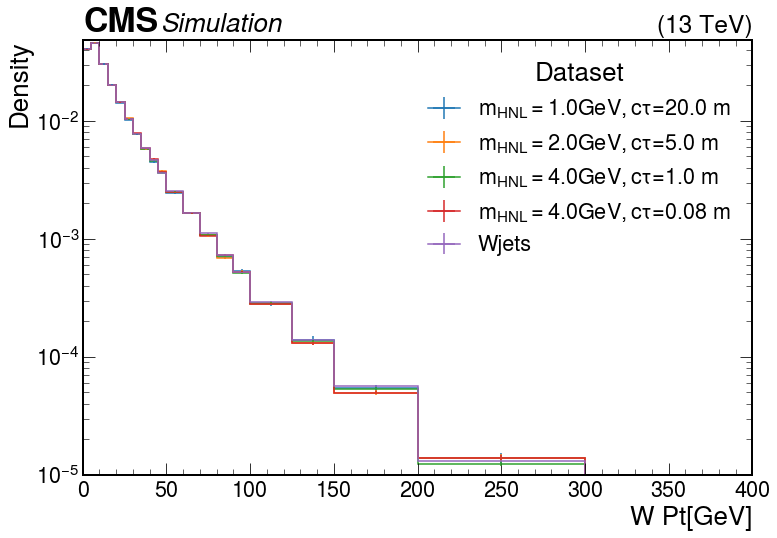

In [467]:
plt.style.use(hep.style.CMS) 
# h = out['gWPt_noweight']
h = out['gWPt']
h.label="Density"
fig, axs = plt.subplots(1,1, figsize=(12,8))
relabel(h)
d = [
'HNL_muonType_mHNL1p0_pl10000_rwctau20000',
 'HNL_muonType_mHNL2p0_pl10000_rwctau5000',
 'HNL_muonType_mHNL4p0_pl1000',
 'HNL_muonType_mHNL4p0_pl100_rwctau80',
 'WJetsToLNu_TuneCP5_13TeV-madgraphMLM-pythia8'
]
hist.plot1d(h[d],density=True)

# f['Wpt'].to_hist().plot1d(ax=axs[0],density=True)
# WJ= axs[0].get_lines()[0].get_ydata()
# with uproot.open("../metadata/WPT.root") as f:
#     wpt_LO = f['Wpt']
# with uproot.open("../metadata/wp-13tev-cms.root") as f:
#     wpt_NLO = f['s_qt']

# wpt_LO.to_hist().plot1d(ax=axs,density=True,label="WJ_LO")
# wpt_NLO.to_hist().plot1d(ax=axs,density=True,label="WJ_NNLO")
axs.set_yscale("log")
axs.set_ylim(1e-5,None)
axs.set_xlim(0,400)
# axs.legend()
hep.cms.label(ax=axs)
fig.savefig("figures/gWPt.pdf")

In [457]:
h_HNL = h.integrate("dataset","HNL_muonType_mHNL4p0_pl1000")
h_WJ = h.integrate("dataset","WJetsToLNu_TuneCP5_13TeV-madgraphMLM-pythia8")
import uproot3
fout = uproot3.recreate('../metadata/WPT_v2.root')
fout['h_HNL'] = hist.export1d(h_HNL)
fout['h_WJ'] = hist.export1d(h_WJ)
fout.close()

# Reco quantities

# Signal MET

In [9]:
h = out['metXYCorr'].project("region")

In [24]:
v=np.array([v for k,v in h.values().items()])
Norm = v.sum()
[(k,v/Norm) for k,v in h.values().items()]

[(('gLLP_csc',), 0.0032733797939286328),
 (('gLLP_dt',), 0.0030198641591355816),
 (('noselection',), 0.7841128093278261),
 (('PreSel',), 0.20942993134159243),
 (('ABCD',), 0.00011154103092587351),
 (('ABCD_OOT',), 5.247434659152988e-05)]

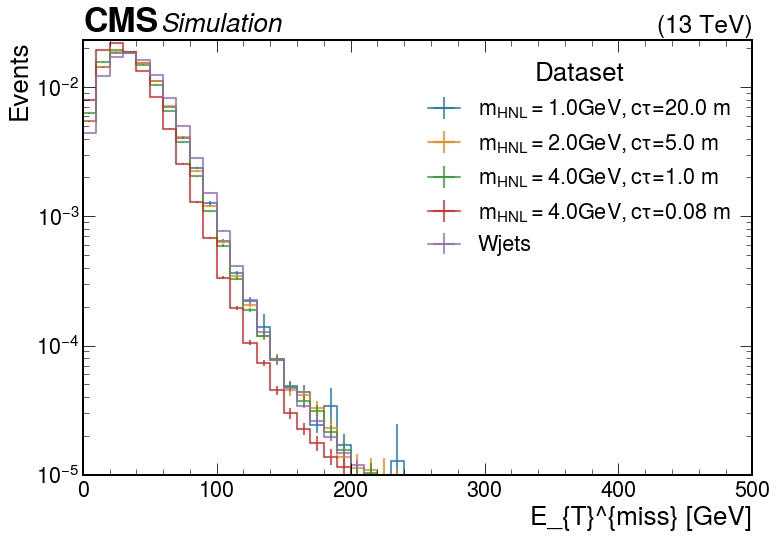

In [479]:
plt.style.use(hep.style.CMS) 
h = out['metXYCorr']
relabel(h)
region=["noselection"]
signals = [
'HNL_muonType_mHNL1p0_pl10000_rwctau20000',
 'HNL_muonType_mHNL2p0_pl10000_rwctau5000',
 'HNL_muonType_mHNL4p0_pl1000',
 'HNL_muonType_mHNL4p0_pl100_rwctau80',
#  'HNL_tauType_mHNL2p0_pl1000'
'WJetsToLNu_TuneCP5_13TeV-madgraphMLM-pythia8'    
]

h = h[signals].integrate("region",region)
h = h.project("dataset","metXYCorr")

fig, axs = plt.subplots(1,1, figsize=(12,8))

# ax = hist.plot1d(h,density=True)
ax = hist.plot1d(h,density=True,clear=False)
# ax = hist.plot1d(h,density=True,ax=ax)
ax.set_yscale("log")
ax.set_ylim(1e-5,None)
hep.cms.label(ax=ax)
fig.savefig("figures/MET.pdf")

(exptext: Custom Text(0.001, 1, 'CMS'),
 expsuffix: Custom Text(0.001, 1.005, 'Simulation'))

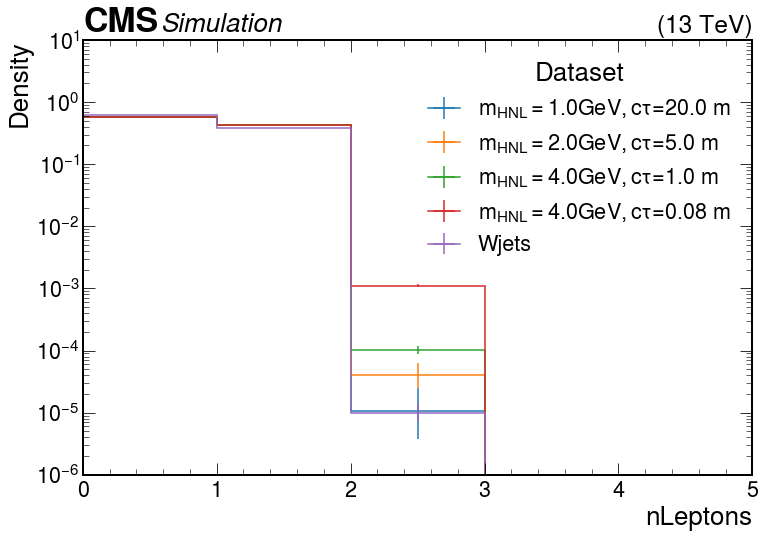

In [46]:
plt.style.use(hep.style.CMS) 
h = out['nLeptons']
h.label="Density"
relabel(h)
fig, axs = plt.subplots(1,1, figsize=(12,8))

hist.plot1d(h[signals_bkg],density=True,ax=axs)
axs.set_yscale("log")
axs.set_ylim(1e-6,10)
hep.cms.label(ax=axs)
# fig.savefig("figures/nLeptons.pdf")

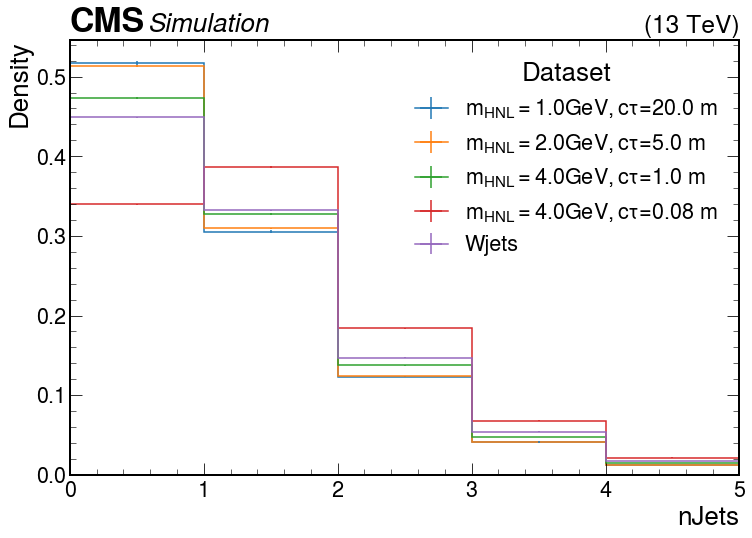

In [485]:
plt.style.use(hep.style.CMS) 
h = out['nJets']
h.label="Density"
relabel(h)
fig, axs = plt.subplots(1,1, figsize=(12,8))

hist.plot1d(h[signals_bkg],density=True,ax=axs)
# ax.set_yscale("log")
# ax.set_ylim(1e-5,None)
hep.cms.label(ax=axs)
fig.savefig("figures/nJets.pdf")

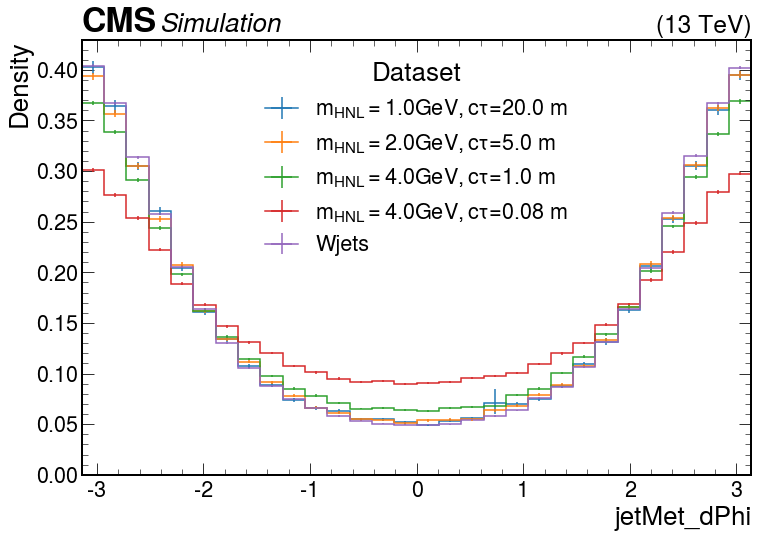

In [486]:
plt.style.use(hep.style.CMS) 
h = out['jetMet_dPhi']
h.label="Density"
relabel(h)
fig, axs = plt.subplots(1,1, figsize=(12,8))

hist.plot1d(h[signals_bkg],density=True,ax=axs)
# ax.set_yscale("log")
# ax.set_ylim(1e-5,None)
hep.cms.label(ax=axs)
fig.savefig("figures/jetMet_dPhi.pdf")

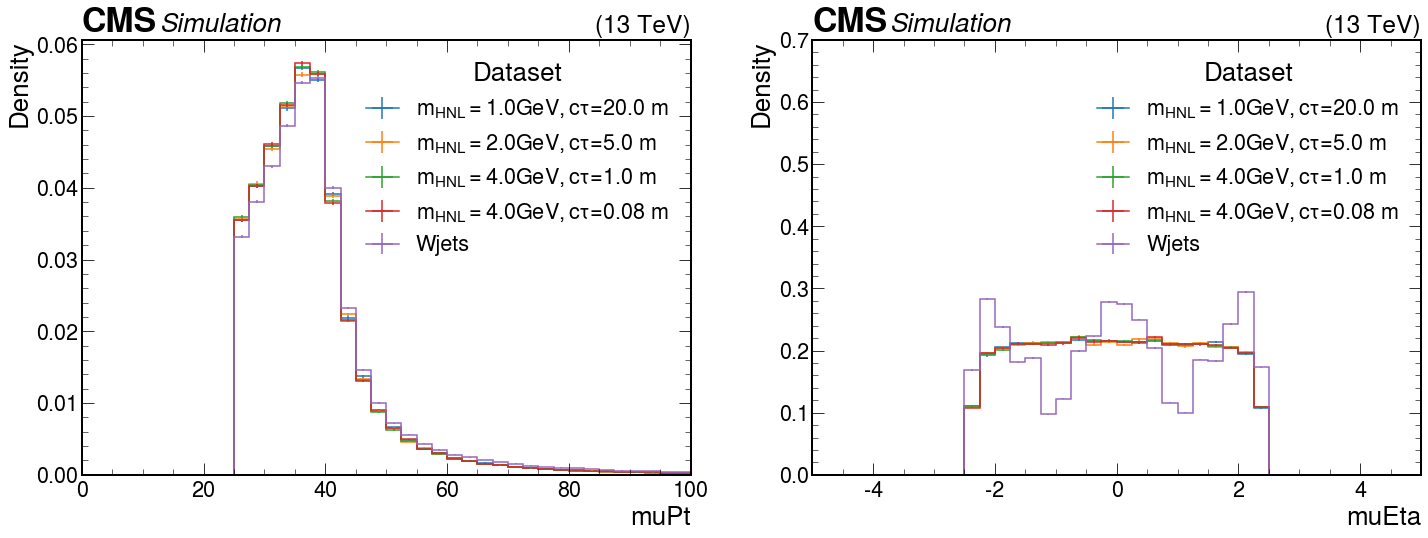

In [491]:
plt.style.use(hep.style.CMS) 
h = out['muPt']
h.label="Density"
relabel(h)
fig, axs = plt.subplots(1,2, figsize=(24,8))
axs=axs.flatten()
hist.plot1d(h[signals_bkg],density=True,ax=axs[0])
h = out['muEta']
h.label="Density"
relabel(h)
hist.plot1d(h[signals_bkg],density=True,ax=axs[1])
axs[1].set_ylim(0,0.7)

# ax.set_yscale("log")
# ax.set_ylim(1e-5,None)
hep.cms.label(ax=axs[0])
hep.cms.label(ax=axs[1])
fig.savefig("figures/muPt_eta.pdf")

(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Simulation'))

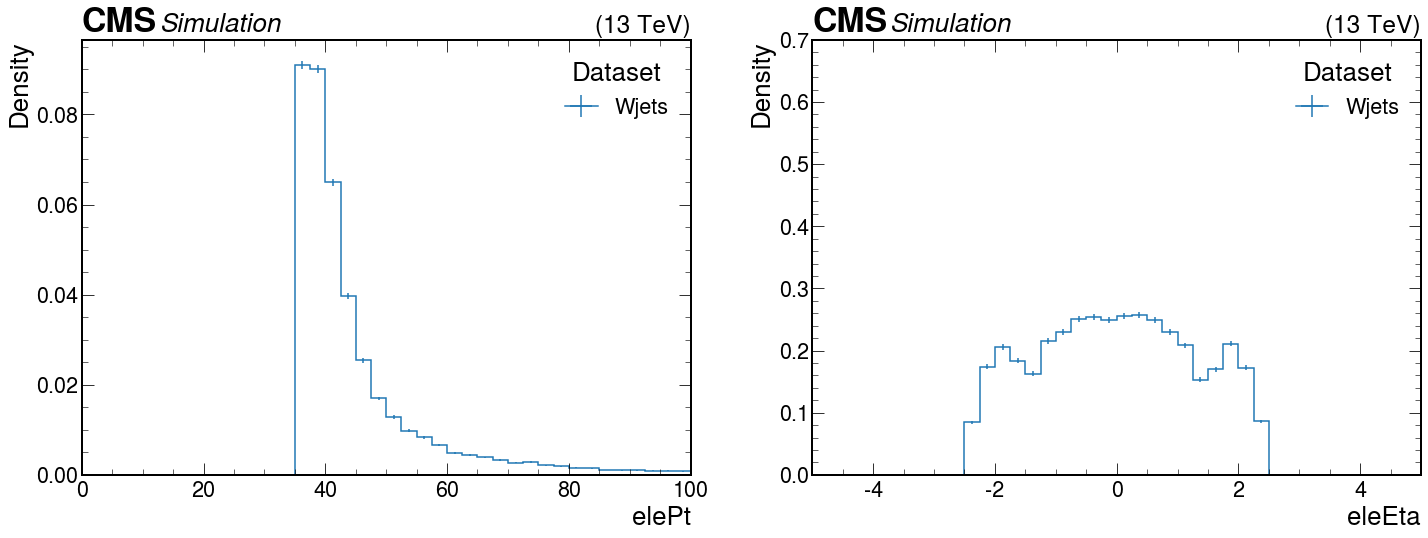

In [494]:
plt.style.use(hep.style.CMS) 
h = out['elePt']
h.label="Density"
relabel(h)
fig, axs = plt.subplots(1,2, figsize=(24,8))
axs=axs.flatten()
hist.plot1d(h[bkg],density=True,ax=axs[0])
h = out['eleEta']
h.label="Density"
relabel(h)
hist.plot1d(h[bkg],density=True,ax=axs[1])
axs[1].set_ylim(0,0.7)

# ax.set_yscale("log")
# ax.set_ylim(1e-5,None)
hep.cms.label(ax=axs[0])
hep.cms.label(ax=axs[1])
# fig.savefig("figures/muPt_eta.pdf")

# Cluster Efficienies

In [1]:
import matplotlib.patches as patches

def plotEff(h_list,ax,axis='e'):
    for h in h_list:
        h_pass=h.integrate('selection',slice(1,None))
        h_pass.label='Cluster Efficiency'
        
        hist.plotratio(
            ax=ax,
            num  =h_pass.project(axis),
            denom=h.project(axis),
            error_opts={'marker': '.'},
            unc='num',
            label=h.identifiers('dataset')[0].label,
            clear=False
        )

    ax.legend(loc='best')
    return ax
def drawCSCsteel(ax,hORv='v'): 
    y_max = ax.get_ylim()[1]
    if hORv=='v':
        ax.axvline(632);ax.axvline(632+39)
        ax.axvline(724);ax.axvline(724+64)
        ax.axvline(849);ax.axvline(849+62)
        ax.axvline(970);ax.axvline(970+32)
    else:
        ax.axhline(632);ax.axhline(632+39)
        ax.axhline(724);ax.axhline(724+64)
        ax.axhline(849);ax.axhline(849+62)
        ax.axhline(970);ax.axhline(970+32)   
        
    ax.text(570, y_max*1.02, 'ME1/1', fontsize=12)
    ax.text(670, y_max*1.02, 'ME1/2-3', fontsize=12)
    ax.text(800, y_max*1.02, 'ME2', fontsize=12)
    ax.text(920, y_max*1.02, 'ME3', fontsize=12)
    ax.text(1015, y_max*1.02,'ME4', fontsize=12)        
    return 

def drawCSCr(ax):
    y_max = ax.get_ylim()[1]
    ax.axvline(350,linestyle="--",color='grey')
    ax.text(350-110,y_max*0.05, "Inner ring", fontsize=15)
    ax.text(350+15 ,y_max*0.05, "Outer ring", fontsize=15)
    return ax

def drawCSCz(ax,text_loc=0.7):    
    ax.set_xlim(550,1075)
    (xmin,xmax) = ax.get_xlim()

    y_max = ax.get_ylim()[1]

    preME11 = patches.Rectangle((xmin, 0), 568-xmin, 2,color='grey',alpha=0.3)
    ME11_12 = patches.Rectangle((632, 0), 39, 2,color='grey',alpha=0.3)
    ME12_2  = patches.Rectangle((724, 0), 65, 2,color='grey',alpha=0.3)
    ME2_3   = patches.Rectangle((849, 0), 62, 2,color='grey',alpha=0.3)
    ME3_4   = patches.Rectangle((970, 0), 32, 2,color='grey',alpha=0.3)
    beyond  = patches.Rectangle((1050, 0),50, 2,color='grey',alpha=0.3)

    ax.text(570, y_max*1.02, 'ME1/1', fontsize=12)
    ax.text(670, y_max*1.02, 'ME1/2-3', fontsize=12)
    ax.text(800, y_max*1.02, 'ME2', fontsize=12)
    ax.text(920, y_max*1.02, 'ME3', fontsize=12)
    ax.text(1015, y_max*1.02,'ME4', fontsize=12)
    ax.text(xmin+5 ,y_max*0.15, "Steel", fontsize=15,rotation=90)
    ax.text(xmax-20,y_max*0.15, "Beyond CMS", fontsize=15,rotation=90)

    ax.add_patch(preME11)
    ax.add_patch(ME11_12)
    ax.add_patch(ME12_2)
    ax.add_patch(ME2_3)
    ax.add_patch(ME3_4)
    ax.add_patch(beyond)
    return ax


def drawDTz(ax):
    y_max = ax.get_ylim()[1]
    ax.axvline(140,linestyle="--",color='grey')
    ax.axvline(400,linestyle="--",color='grey')    

    ax.text(140-110,y_max*0.05, "Wheel 0", fontsize=15)
    ax.text(220 ,y_max*0.05, "Wheel 1", fontsize=15)
    ax.text(500 ,y_max*0.05, "Wheel 2", fontsize=15)    
    return ax

def drawDTr(ax,text_loc=0.7):    
    ax.set_xlim(350,760)
    (xmin,xmax) = ax.get_xlim()

    y_max = ax.get_ylim()[1]

    preMB1 = patches.Rectangle((xmin, 0), 405-xmin, 2,color='grey',alpha=0.3)
    MB1_2  = patches.Rectangle((465, 0) , 20, 2,color='grey',alpha=0.3)
    MB2_3  = patches.Rectangle((540, 0) , 55, 2,color='grey',alpha=0.3)
    MB3_4  = patches.Rectangle((640, 0) , 60, 2,color='grey',alpha=0.3)
    

    ax.text(420, y_max*1.02, 'MB1', fontsize=12)
    ax.text(500, y_max*1.02, 'MB2', fontsize=12)
    ax.text(600, y_max*1.02, 'MB3', fontsize=12)
    ax.text(710, y_max*1.02, 'MB4', fontsize=12)
    ax.axvline(740,linestyle="--",color='grey')    
    
    ax.text(xmin+5 ,y_max*0.15, "Steel/Solenoid", fontsize=15,rotation=90)
    ax.text(xmax-10,y_max*0.15, "Beyond CMS", fontsize=15,rotation=90)
    

    ax.add_patch(preMB1)
    ax.add_patch(MB1_2)
    ax.add_patch(MB2_3)
    ax.add_patch(MB3_4)
    return ax

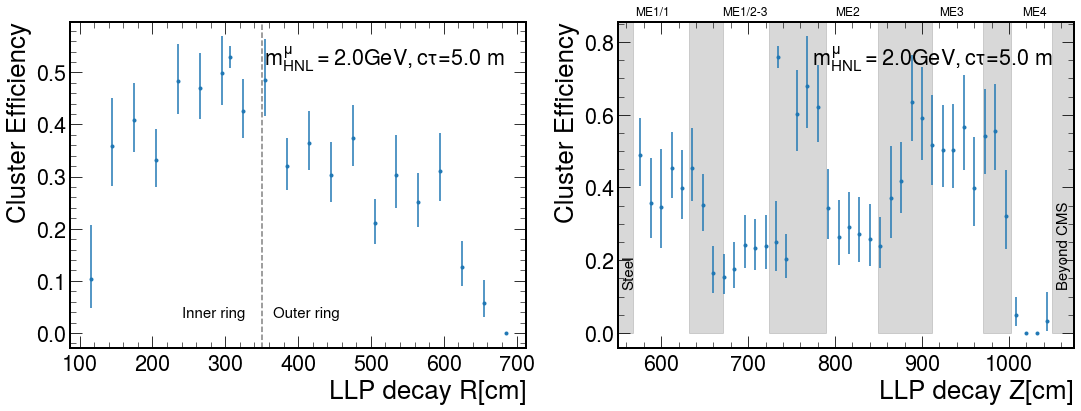

In [13]:
plt.style.use(hep.style.CMS) 

datasets = [
#  'HNL_muonType_mHNL1p0_pl10000',
#  'HNL_muonType_mHNL1p0_pl10000_rwctau20000',
 'HNL_muonType_mHNL2p0_pl10000_rwctau5000',
#  'HNL_muonType_mHNL4p0_pl1000',
#  'HNL_muonType_mHNL4p0_pl100_rwctau80',
#  'WJetsToLNu_TuneCP5_13TeV-madgraphMLM-pythia8'
]

figsize=(18,6)
fig, axs = plt.subplots(1,2,figsize=figsize)

axs= axs.flatten()
hz =out['llp_cls_eff_z']
hr=out['llp_cls_eff_r']
relabel(hz)
relabel(hr)

plotEff([hr[d] for d in datasets],axs[0],"r")
plotEff([hz[d] for d in datasets],axs[1],"z")
drawCSCz(axs[1])
drawCSCr(axs[0])
axs[0].legend(loc=1)
# hep.cms.label(ax=ax)
# fig.savefig("figures/cls_eff_rz_mHNL4_ct1m.pdf")
# fig.savefig("figures/cls_eff_rz_mHNL4_ct8cm.pdf")
fig.savefig("figures/cls_eff_rz_mHNL2_ct5m.pdf")
# fig.savefig("figures/cls_eff_rz_mHNL1_ct20m.pdf")

/uscms/home/kkwok/work/LLP/CMSSW_10_6_20/src/llp_analyzer/coffeaenv/lib/python3.7/site-packages/coffea/hist/plot.py:427: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom
/uscms/home/kkwok/work/LLP/CMSSW_10_6_20/src/llp_analyzer/coffeaenv/lib/python3.7/site-packages/coffea/hist/plot.py:439: RuntimeWarning: invalid value encountered in true_divide
  poisson_interval(rsumw, sumw2_num / sumw_denom**2) - rsumw
/cvmfs/sft.cern.ch/lcg/views/LCG_98python3/x86_64-centos7-gcc9-opt/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:881: RuntimeWarning: invalid value encountered in greater
  cond = logical_and(cond, (asarray(arg) > 0))
/uscms/home/kkwok/work/LLP/CMSSW_10_6_20/src/llp_analyzer/coffeaenv/lib/python3.7/site-packages/coffea/hist/plot.py:427: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom
/uscms/home/kkwok/work/LLP/CMSSW_10_6_20/src/llp_analyzer/coffeaenv/lib/python3.7/site-packages/coffea/h

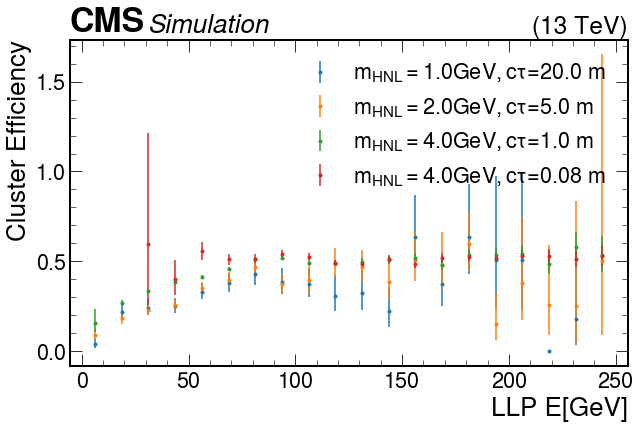

In [316]:
plt.style.use(hep.style.CMS) 

datasets = [
#  'HNL_muonType_mHNL1p0_pl10000',
 'HNL_muonType_mHNL1p0_pl10000_rwctau20000',
 'HNL_muonType_mHNL2p0_pl10000_rwctau5000',
 'HNL_muonType_mHNL4p0_pl1000',
 'HNL_muonType_mHNL4p0_pl100_rwctau80',
#  'WJetsToLNu_TuneCP5_13TeV-madgraphMLM-pythia8'
]

figsize=(10,6)
fig, axs = plt.subplots(1,1,figsize=figsize)

he=out['llp_cls_eff_e']

relabel(he)

plotEff([he[d] for d in datasets],axs,"e")
# axs.legend(title="")
hep.cms.label(ax=axs)
fig.savefig("figures/cls_eff_E.pdf")

## DT cluster efficiencies

/uscms/home/kkwok/work/LLP/CMSSW_10_6_20/src/llp_analyzer/coffeaenv/lib/python3.7/site-packages/coffea/hist/plot.py:427: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom
/uscms/home/kkwok/work/LLP/CMSSW_10_6_20/src/llp_analyzer/coffeaenv/lib/python3.7/site-packages/coffea/hist/plot.py:439: RuntimeWarning: invalid value encountered in true_divide
  poisson_interval(rsumw, sumw2_num / sumw_denom**2) - rsumw
/cvmfs/sft.cern.ch/lcg/views/LCG_98python3/x86_64-centos7-gcc9-opt/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:881: RuntimeWarning: invalid value encountered in greater
  cond = logical_and(cond, (asarray(arg) > 0))
/uscms/home/kkwok/work/LLP/CMSSW_10_6_20/src/llp_analyzer/coffeaenv/lib/python3.7/site-packages/coffea/hist/plot.py:427: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom
/uscms/home/kkwok/work/LLP/CMSSW_10_6_20/src/llp_analyzer/coffeaenv/lib/python3.7/site-packages/coffea/h

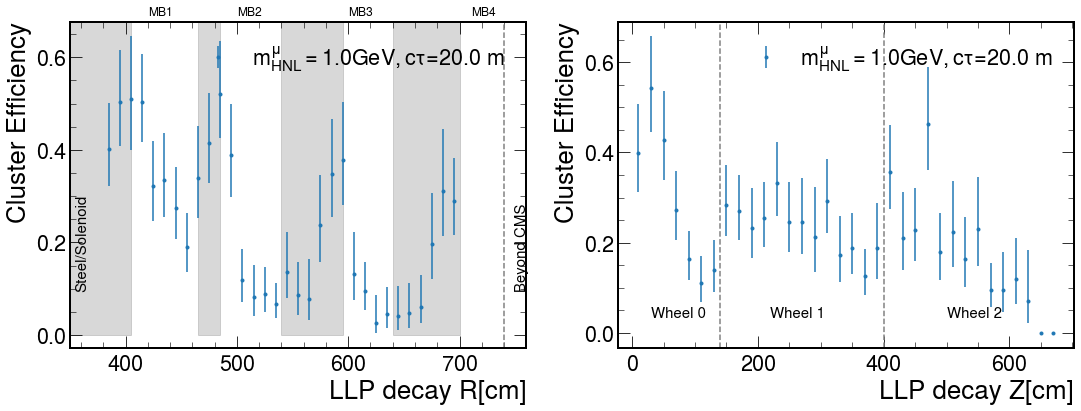

In [16]:
plt.style.use(hep.style.CMS) 

datasets = [
#  'HNL_muonType_mHNL1p0_pl10000',
 'HNL_muonType_mHNL1p0_pl10000_rwctau20000',
#  'HNL_muonType_mHNL2p0_pl10000_rwctau5000',
#  'HNL_muonType_mHNL4p0_pl1000',
#  'HNL_muonType_mHNL4p0_pl100_rwctau80',
#  'WJetsToLNu_TuneCP5_13TeV-madgraphMLM-pythia8'
]

figsize=(18,6)
fig, axs = plt.subplots(1,2,figsize=figsize)

axs= axs.flatten()
hz=out['llp_cls_dt_eff_z']
hr=out['llp_cls_dt_eff_r']
relabel(hz)
relabel(hr)

plotEff([hr[d] for d in datasets],axs[0],"r")
plotEff([hz[d] for d in datasets],axs[1],"z")
# axs[0].set_ylim(0,0.7)
# axs[1].set_ylim(0,0.7)
drawDTz(axs[1])
drawDTr(axs[0])
axs[0].legend(loc=1)
axs[1].legend(loc=1)
fig.savefig("figures/cls_dt_eff_rz_mHNL1_ct20m.pdf")
# fig.savefig("figures/cls_dt_eff_rz_mHNL2_ct5m.pdf")
# fig.savefig("figures/cls_dt_eff_rz_mHNL4_ct1m.pdf")
# fig.savefig("figures/cls_dt_eff_rz_mHNL4_ct8cm.pdf")

/uscms/home/kkwok/work/LLP/CMSSW_10_6_20/src/llp_analyzer/coffeaenv/lib/python3.7/site-packages/coffea/hist/plot.py:427: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom
/uscms/home/kkwok/work/LLP/CMSSW_10_6_20/src/llp_analyzer/coffeaenv/lib/python3.7/site-packages/coffea/hist/plot.py:439: RuntimeWarning: invalid value encountered in true_divide
  poisson_interval(rsumw, sumw2_num / sumw_denom**2) - rsumw
/cvmfs/sft.cern.ch/lcg/views/LCG_98python3/x86_64-centos7-gcc9-opt/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:881: RuntimeWarning: invalid value encountered in greater
  cond = logical_and(cond, (asarray(arg) > 0))
/uscms/home/kkwok/work/LLP/CMSSW_10_6_20/src/llp_analyzer/coffeaenv/lib/python3.7/site-packages/coffea/hist/plot.py:427: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom
/uscms/home/kkwok/work/LLP/CMSSW_10_6_20/src/llp_analyzer/coffeaenv/lib/python3.7/site-packages/coffea/h

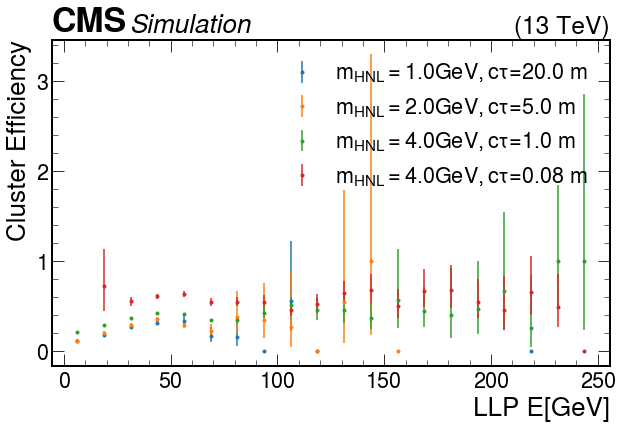

In [427]:
plt.style.use(hep.style.CMS) 

datasets = [
 'HNL_muonType_mHNL1p0_pl10000_rwctau20000',
 'HNL_muonType_mHNL2p0_pl10000_rwctau5000',
 'HNL_muonType_mHNL4p0_pl1000',
 'HNL_muonType_mHNL4p0_pl100_rwctau80',
]

figsize=(10,6)
fig, axs = plt.subplots(1,1,figsize=figsize)

he=out['llp_cls_dt_eff_e']

relabel(he)

plotEff([he[d] for d in datasets],axs,"e")
# axs.legend(title="")
hep.cms.label(ax=axs)
fig.savefig("figures/cls_dt_eff_E.pdf")

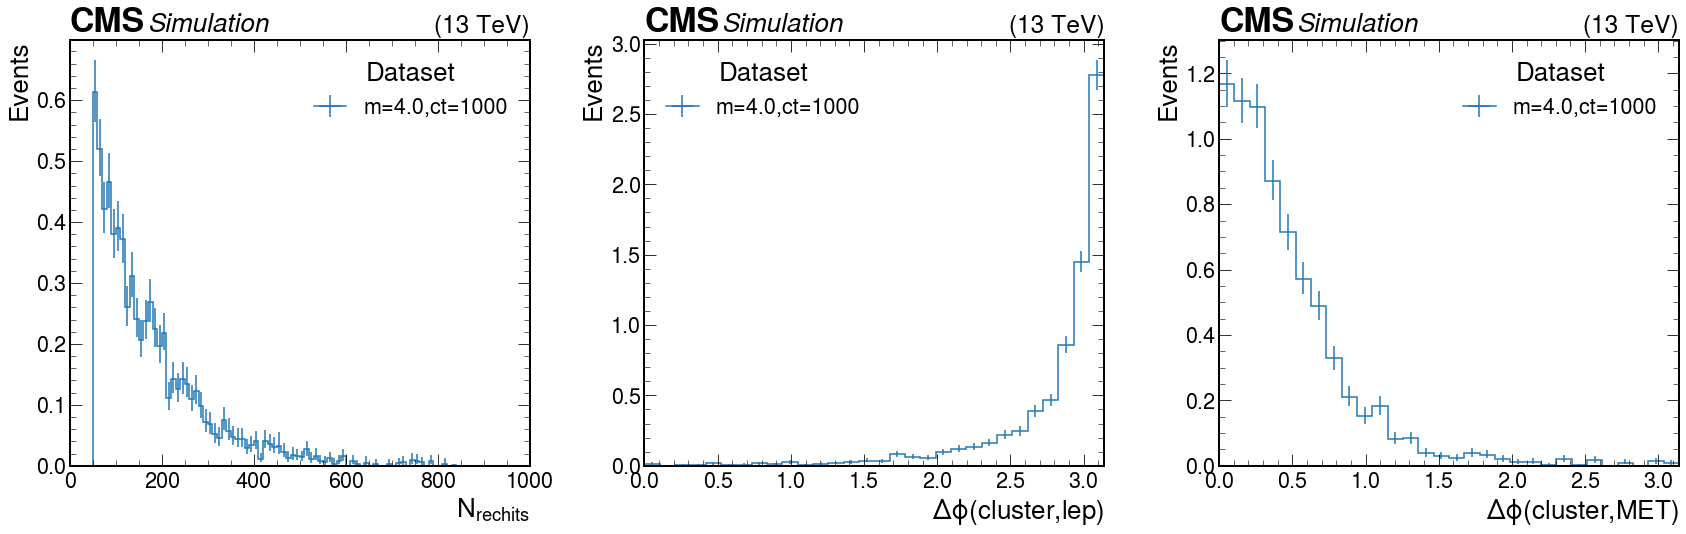

In [35]:
h = out_s['dphi_cluster_csc']
h = h['HNL_muonType_mHNL4p0_pl1000'].integrate("region","ABCD")
plt.style.use(hep.style.CMS) 

fig, axs = plt.subplots(1,3, figsize=(24,8))
axs = axs.flatten()

hist.plot1d(h.project("ClusterSize","dataset"),ax=axs[0])
hist.plot1d(h.project("dphi_lep","dataset"),ax=axs[1])
hist.plot1d(h.project("dphi_MET","dataset"),ax=axs[2])

for ax in axs:
    hep.cms.label(ax=ax,label="",data=False)
# axs[0].legend(["OOT","InTime"])    
#     ax.set_xlabel("ClusterSize cut")
#     ax.set_ylabel("dphi_lep cut")    
    
plt.tight_layout()

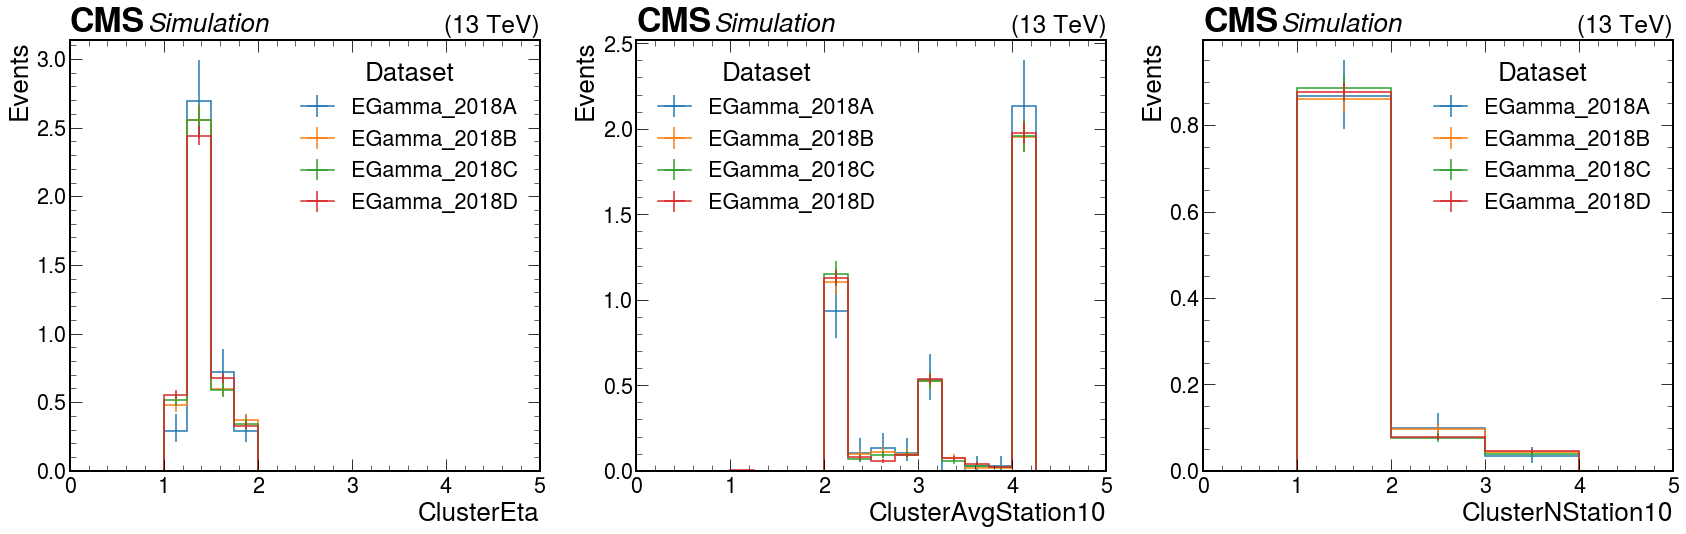

In [162]:
#
# h = out['Cluster']
h1=out['ClusterEta'][signals].integrate("region","ABCD_OOT")
h2=out['ClusterAvgStation10'][signals].integrate("region","ABCD_OOT")
h3=out['ClusterNStation10'][signals].integrate("region","ABCD_OOT")

plt.style.use(hep.style.CMS) 

fig, axs = plt.subplots(1,3, figsize=(24,8))
axs = axs.flatten()

hist.plot1d(h1.project("ClusterEta","dataset"),ax=axs[0],density=True)
hist.plot1d(h2.project("ClusterAvgStation10","dataset"),ax=axs[1],density=True)
hist.plot1d(h3.project("ClusterNStation10","dataset"),ax=axs[2],density=True)

for ax in axs:
    hep.cms.label(ax=ax,label="",data=False)
  
axs[0].set_xlim(0,None)
plt.tight_layout()